In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## ONLY RERUN FOR VERIFICATION ##

# def merge_csv_files_with_correct_format(directory='Dataset', output_filepath='final_merged.csv'):
#     # List to hold individual dataframes
#     dfs = []

#     # Corrected timestamp format string for 24-hour time format
#     timestamp_format = "%d/%m/%Y %H:%M:%S"

#     # Loop through each file in the directory
#     for filename in os.listdir(directory):
#         if filename.endswith(".csv"):
#             # Create a full file path
#             filepath = os.path.join(directory, filename)

#             # Read the CSV file into a DataFrame
#             df = pd.read_csv(filepath)

#             # Convert the timestamp column to datetime format using the corrected format string
#             try:
#                 df['timestamp'] = pd.to_datetime(df['timestamp'], format=timestamp_format)
#             except Exception as e:
#                 print(f"Error in converting timestamp for file {filename}: {e}")

#             # Append the dataframe to the list
#             dfs.append(df)

#     # Concatenate all the DataFrames in the list into a single DataFrame
#     merged_data = pd.concat(dfs, ignore_index=True)

#     # Sort the merged dataframe by the 'timestamp' column
#     merged_data = merged_data.sort_values(by='timestamp').reset_index(drop=True)

#     # Save the merged DataFrame to a CSV file
#     merged_data.to_csv(output_filepath, index=False)

# # Return the modified function for demonstration
# merge_csv_files_with_correct_format


In [3]:
# merge_csv_files_with_correct_format(directory='Dataset', output_filepath='final_merged.csv')


In [43]:
final_merged = pd.read_csv('final_merged.csv')


# Convert'timestamp'to datetime format
final_merged['timestamp'] = pd.to_datetime(final_merged['timestamp'])


final_merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49312 entries, 0 to 49311
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  49312 non-null  datetime64[ns]
 1   Actiwatch activity counts  49100 non-null  float64       
 2   Actiware classification    48919 non-null  float64       
 3   Apple Watch ENMO           49278 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [44]:
# Extract unique day-month combinations from the 'timestamp' column of the filtered data
unique_day_month = final_merged['timestamp'].dt.strftime('%d-%B').unique()

# Return the unique day-month combinations in the filtered data
unique_day_month


array(['01-January', '02-January', '03-January', '04-January',
       '05-January', '06-January', '07-January', '08-January',
       '09-January', '10-January', '11-January', '12-January',
       '13-January', '14-January', '15-January', '16-January',
       '17-January', '18-January', '19-January', '20-January',
       '21-January', '22-January', '23-January', '24-January',
       '25-January', '26-January', '27-January', '28-January'],
      dtype=object)

In [45]:
summary_january_data = final_merged.describe(include='all')

# missing values count
missing_values_january_data = final_merged.isnull().sum()

summary_january_data, missing_values_january_data


(                           timestamp  Actiwatch activity counts  \
 count                          49312               49100.000000   
 mean   2000-01-14 12:06:48.548020864                   4.110468   
 min              2000-01-01 01:17:00                   0.000000   
 25%       2000-01-07 03:48:56.250000                   0.000000   
 50%       2000-01-15 02:48:52.500000                   0.000000   
 75%       2000-01-21 01:35:48.750000                   0.000000   
 max              2000-01-28 08:57:45                 880.000000   
 std                              NaN                  24.561319   
 
        Actiware classification  Apple Watch ENMO  
 count             48919.000000      49278.000000  
 mean                  0.079642          0.006621  
 min                   0.000000          0.000505  
 25%                   0.000000          0.001897  
 50%                   0.000000          0.003029  
 75%                   0.000000          0.004746  
 max                  

In [46]:
# Drop Unnecessary Columns
january_data = final_merged.drop(columns=['Actiwatch activity counts'])

# Handling Missing Values:
# Since 'Actiware classification' is our ground truth, we'll drop rows where this column has missing values
# For 'Apple Watch ENMO', we'll replace missing values with the median of the column
january_data = january_data.dropna(subset=['Actiware classification'])
january_data['Apple Watch ENMO'].fillna(january_data['Apple Watch ENMO'].median(), inplace=True)

january_data.head()


,timestamp,Actiware classification,Apple Watch ENMO
15,2000-01-01 01:20:45,1.0,0.007234
16,2000-01-01 01:21:00,1.0,0.030109
17,2000-01-01 01:21:15,1.0,0.008785
18,2000-01-01 01:21:30,1.0,0.007893
19,2000-01-01 01:21:45,1.0,0.007761


In [47]:
print(january_data.isnull().sum())

timestamp                  0
Actiware classification    0
Apple Watch ENMO           0
dtype: int64


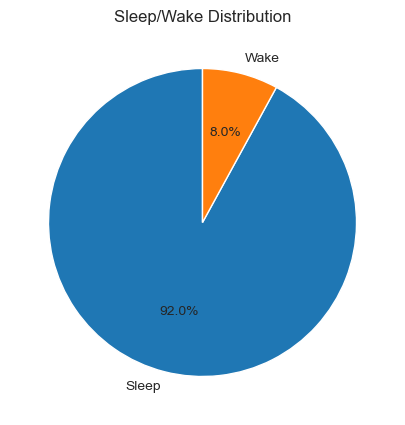

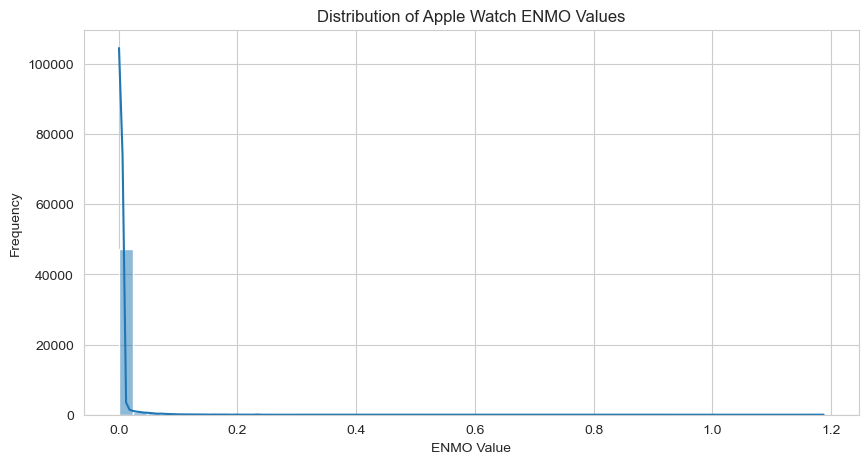

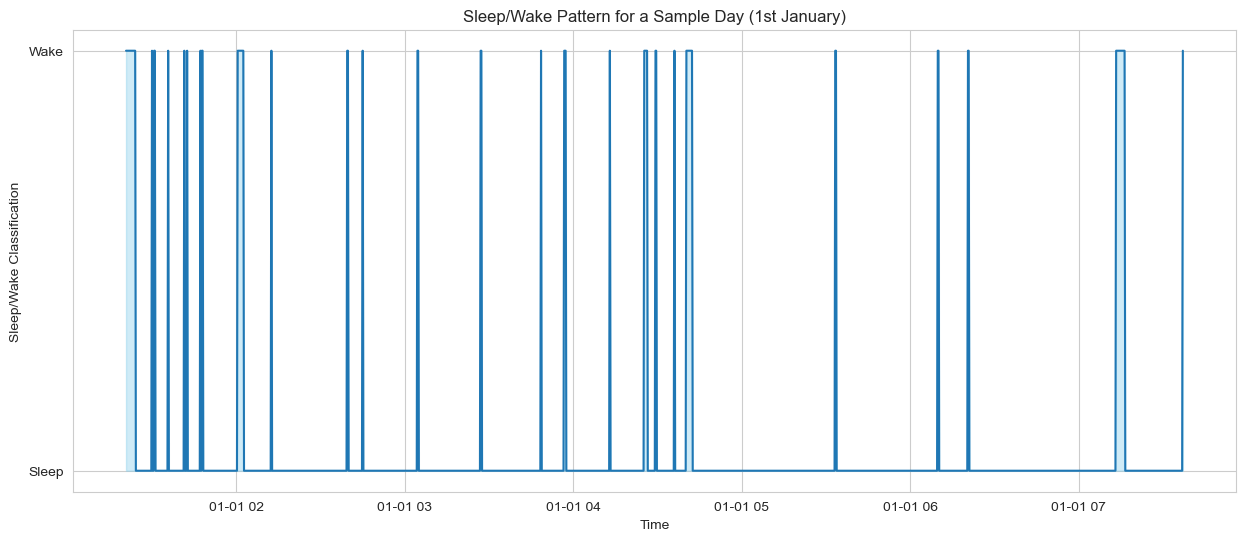

In [48]:
sns.set_style("whitegrid")

# Sleep/Wake Distribution:
plt.figure(figsize=(10, 5))
january_data['Actiware classification'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Sleep', 'Wake'])
plt.title('Sleep/Wake Distribution')
plt.ylabel('')  # Remove the default ylabel
plt.show()

# Visualizing ENMO values:
plt.figure(figsize=(10, 5))
sns.histplot(january_data['Apple Watch ENMO'], bins=50, kde=True)
plt.title('Distribution of Apple Watch ENMO Values')
plt.xlabel('ENMO Value')
plt.ylabel('Frequency')
plt.show()

# Sleep/Wake patterns over time (sample day):
sample_day_data = january_data[january_data['timestamp'].dt.day == 1]
plt.figure(figsize=(15, 6))
plt.plot(sample_day_data['timestamp'], sample_day_data['Actiware classification'])
plt.fill_between(sample_day_data['timestamp'], sample_day_data['Actiware classification'], color='skyblue', alpha=0.4)
plt.title('Sleep/Wake Pattern for a Sample Day (1st January)')
plt.xlabel('Time')
plt.ylabel('Sleep/Wake Classification')
plt.yticks([0, 1], ['Sleep', 'Wake'])
plt.show()


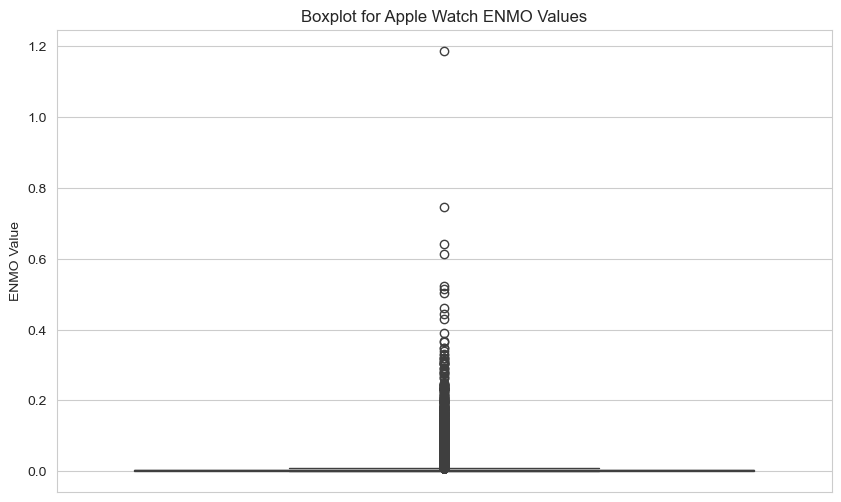

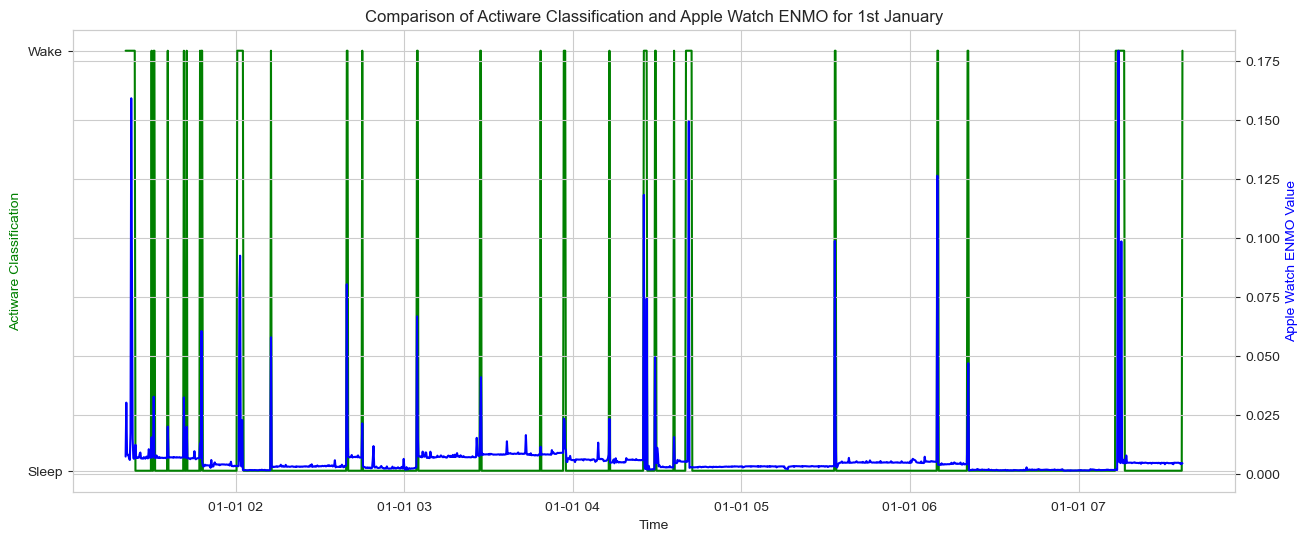

C:\Users\markw\AppData\Local\Temp\ipykernel_20648\2098070340.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(january_data[january_data['Actiware classification'] == 0]['Apple Watch ENMO'], shade=True, label='Sleep')
C:\Users\markw\AppData\Local\Temp\ipykernel_20648\2098070340.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(january_data[january_data['Actiware classification'] == 1]['Apple Watch ENMO'], shade=True, label='Wake')


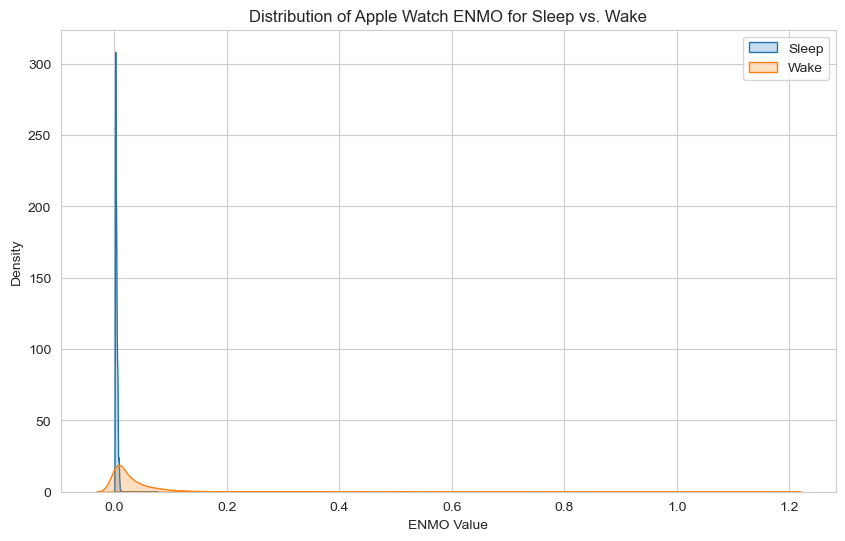

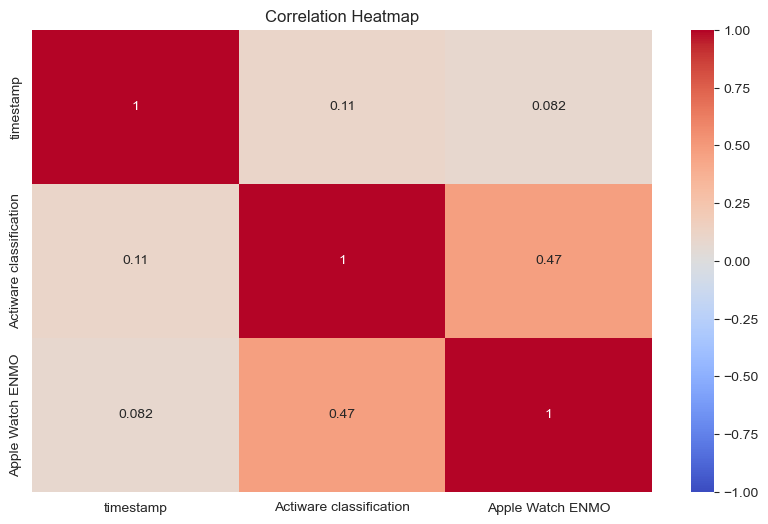

In [49]:
# Boxplot for Apple Watch ENMO
plt.figure(figsize=(10, 6))
sns.boxplot(y=january_data['Apple Watch ENMO'])
plt.title('Boxplot for Apple Watch ENMO Values')
plt.ylabel('ENMO Value')
plt.show()

# Time Series Comparison of Actiware Classification and Apple Watch ENMO
# For clarity, plotting a sample day (1st January)
sample_day_data = january_data[january_data['timestamp'].dt.day == 1]
fig, ax1 = plt.subplots(figsize=(15, 6))


ax2 = ax1.twinx()

ax1.plot(sample_day_data['timestamp'], sample_day_data['Actiware classification'], 'g-')
ax1.set_ylabel('Actiware Classification', color='g')
ax1.set_xlabel('Time')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Sleep', 'Wake'])

ax2.plot(sample_day_data['timestamp'], sample_day_data['Apple Watch ENMO'], 'b-')
ax2.set_ylabel('Apple Watch ENMO Value', color='b')

plt.title('Comparison of Actiware Classification and Apple Watch ENMO for 1st January')
plt.show()

# Distribution of Apple Watch ENMO for Sleep vs. Wake
plt.figure(figsize=(10, 6))
sns.kdeplot(january_data[january_data['Actiware classification'] == 0]['Apple Watch ENMO'], shade=True, label='Sleep')
sns.kdeplot(january_data[january_data['Actiware classification'] == 1]['Apple Watch ENMO'], shade=True, label='Wake')
plt.title('Distribution of Apple Watch ENMO for Sleep vs. Wake')
plt.xlabel('ENMO Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Correlation Heatmap
corr_matrix = january_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


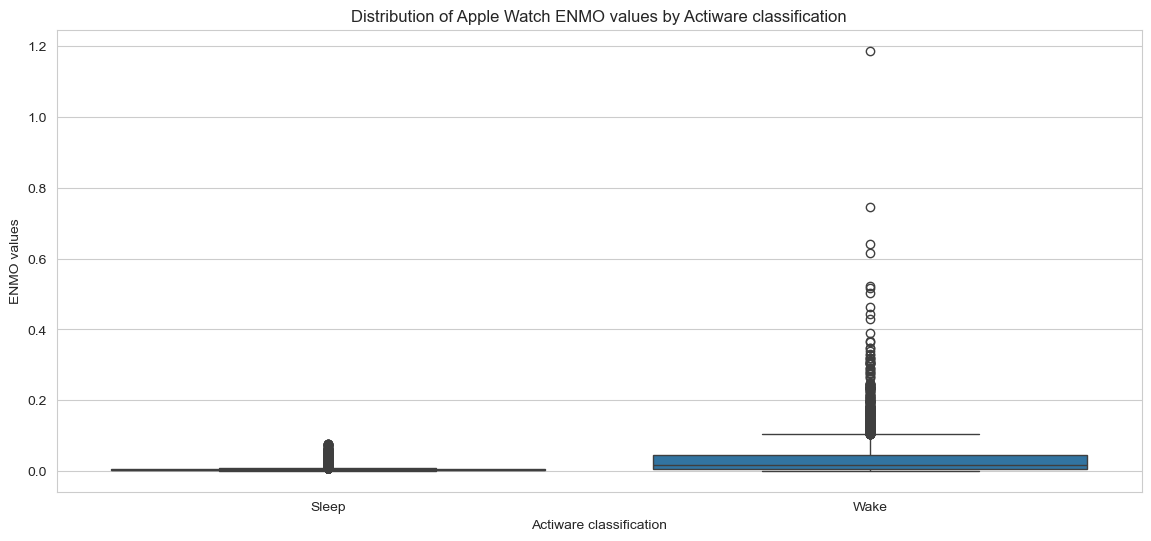

In [50]:
# Distribution of Apple Watch ENMO values based on Actiware classification
plt.figure(figsize=(14, 6))
sns.boxplot(x=january_data['Actiware classification'], y=january_data['Apple Watch ENMO'])
plt.title('Distribution of Apple Watch ENMO values by Actiware classification')
plt.xticks([0, 1], ['Sleep', 'Wake'])
plt.ylabel('ENMO values')
plt.show()


In [51]:
# Split dataset
X = january_data[['Apple Watch ENMO']]
y = january_data['Actiware classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

X_train.shape, X_test.shape

((34243, 1), (14676, 1))

In [52]:
print(y_test.describe())

count    14676.000000
mean         0.077065
std          0.266703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Actiware classification, dtype: float64


In [53]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

print(y_train.isnull().sum()) 
print(y_test.isnull().sum())  

Apple Watch ENMO    0
dtype: int64
Apple Watch ENMO    0
dtype: int64
0
0


In [54]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=3)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)



Accuracy: 0.94
ROC AUC Score: 0.63

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     13545
         1.0       0.93      0.25      0.40      1131

    accuracy                           0.94     14676
   macro avg       0.94      0.63      0.68     14676
weighted avg       0.94      0.94      0.93     14676

[[13524    21]
 [  843   288]]


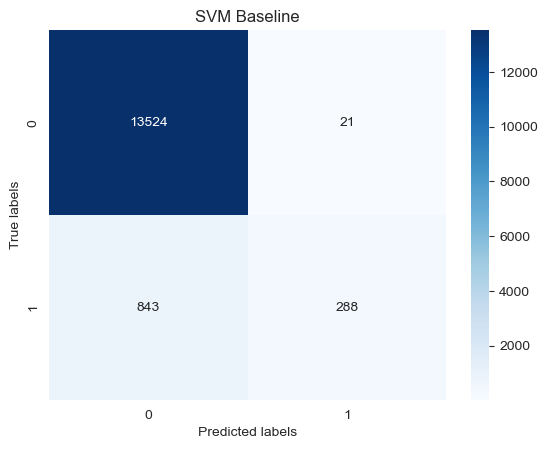

In [55]:
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Baseline')
plt.show()

In [56]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {0: class_weights[0], 1: class_weights[1]}

weights

{0: 0.5439195628693055, 1: 6.1922242314647375}

In [19]:

# Assign class weights to handle imbalance. 
svm_classifier_weights = SVC(kernel='linear', C=1, class_weight=weights, random_state=3)
svm_classifier_weights.fit(X_train, y_train)
y_pred_weights = svm_classifier_weights.predict(X_test)

# Evaluate model
accuracy_weights = accuracy_score(y_test, y_pred_weights)
roc_auc_weights = roc_auc_score(y_test, y_pred_weights)
report_weights = classification_report(y_test, y_pred_weights)

print(f"Accuracy: {accuracy_weights:.2f}")
print(f"ROC AUC Score: {roc_auc_weights:.2f}")
print("\nClassification Report:\n", report_weights)


# Confusion Matrix
conf_matrix_weights = confusion_matrix(y_test, y_pred_weights)
print(conf_matrix_weights)



Accuracy: 0.96
ROC AUC Score: 0.74

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     13545
         1.0       0.91      0.48      0.63      1131

    accuracy                           0.96     14676
   macro avg       0.93      0.74      0.80     14676
weighted avg       0.95      0.96      0.95     14676

[[13489    56]
 [  586   545]]


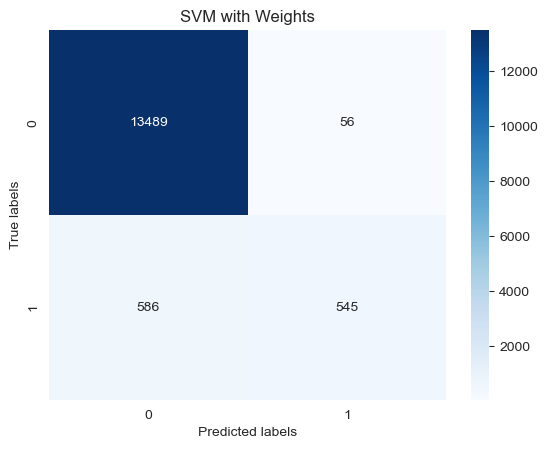

In [20]:
sns.heatmap(conf_matrix_weights, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM with Weights')
plt.show()

In [21]:
## RERUN FOR VERIFICATION ##

# # Defin hyperparameters grid
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', ''],
#     'gamma': ['scale', 'auto']
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     SVC(random_state=3),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=4,
#     n_jobs=-1  
# )

# # Run GridSearchCV
# grid_search.fit(X_train, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_:.4f}")

In [35]:
# # Save best hyperparameters
# with open('best_params.pkl', 'wb') as file:
#     pickle.dump(grid_search.best_params_, file)

# # load function
# with open('best_params.pkl', 'rb') as file:
#     loaded_best_params = pickle.load(file)

# print("Loaded Parameters:", loaded_best_params)

Accuracy: 0.95
ROC AUC Score: 0.79

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     13545
         1.0       0.72      0.61      0.66      1131

    accuracy                           0.95     14676
   macro avg       0.84      0.79      0.82     14676
weighted avg       0.95      0.95      0.95     14676

[[13279   266]
 [  446   685]]


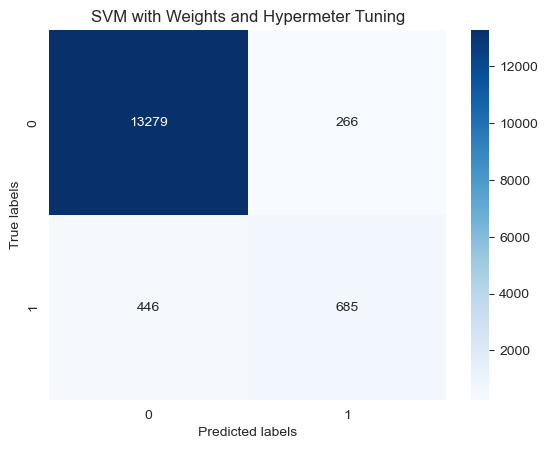

In [23]:
# Retrain the tuned model 
svm_classifier_htweights = SVC(C=10, gamma='scale', kernel='rbf', class_weight=weights, random_state=3)
svm_classifier_htweights.fit(X_train, y_train)
y_pred_htweights = svm_classifier_htweights.predict(X_test)

accuracy_htweights = accuracy_score(y_test, y_pred_htweights)
roc_auc_htweights = roc_auc_score(y_test, y_pred_htweights)
report_htweights = classification_report(y_test, y_pred_htweights)

print(f"Accuracy: {accuracy_htweights:.2f}")
print(f"ROC AUC Score: {roc_auc_htweights:.2f}")
print("\nClassification Report:\n", report_htweights)

conf_matrix_htweights = confusion_matrix(y_test, y_pred_htweights)
print(conf_matrix_htweights)

sns.heatmap(conf_matrix_htweights, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM with Weights and Hypermeter Tuning')
plt.show()

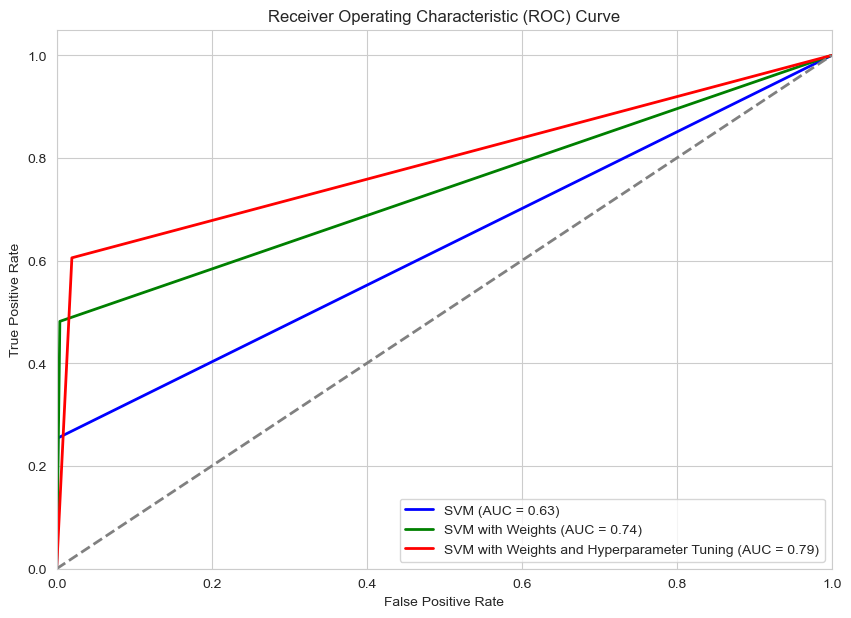

In [57]:
# Get and plot the ROC curve values for the three models
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_weights, tpr_weights, _ = roc_curve(y_test, y_pred_weights)
roc_auc_weights = auc(fpr_weights, tpr_weights)

fpr_htweights, tpr_htweights, _ = roc_curve(y_test, y_pred_htweights)
roc_auc_htweights = auc(fpr_htweights, tpr_htweights)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot(fpr_weights, tpr_weights, color='green', lw=2, label=f'SVM with Weights (AUC = {roc_auc_weights:.2f})')
plt.plot(fpr_htweights, tpr_htweights, color='red', lw=2, label=f'SVM with Weights and Hyperparameter Tuning (AUC = {roc_auc_htweights:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


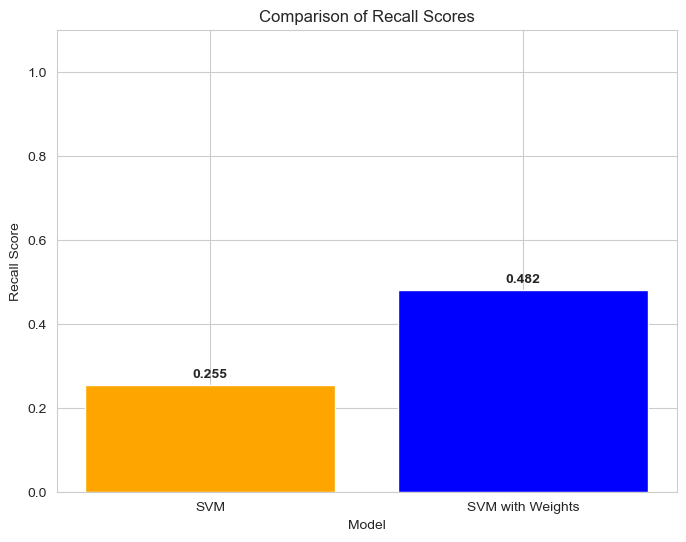

In [58]:
# Calculate recall scores
recall_svm = recall_score(y_test, y_pred)
recall_svm_weights = recall_score(y_test, y_pred_weights)

# Data for the bar plot
models = ['SVM', 'SVM with Weights']
recall_scores = [recall_svm, recall_svm_weights]

plt.figure(figsize=(8, 6))
plt.bar(models, recall_scores, color=['orange', 'blue'])
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Comparison of Recall Scores')
plt.ylim(0, 1.1)  # adjust this for better visualization if needed
for i, v in enumerate(recall_scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
plt.show()


In [59]:
def compute_sleep_metrics(predictions):
    """
    Compute the foundational sleep metrics based on the predictions.
    """
    # Total Sleep Time (TST)
    TST = len(predictions[predictions == 0]) * 15  # each epoch is 15 seconds

    # Total Wake Time (TWT)
    TWT = len(predictions[predictions == 1]) * 15  # each epoch is 15 seconds

    # Sleep Efficiency (SE)
    SE = (TST / (TST + TWT)) * 100

    return TST, TWT, SE

In [60]:
def refine_predictions_5min(preds):
    """
    Refine the predictions based on the continuity rules for 5 minutes of uninterrupted sleep..
    """
    # Convert predictions to a list for easier processing
    refined_preds = preds.tolist()

    # First 5 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 20):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            # Set all epochs before this to wake
            for j in range(i):
                refined_preds[j] = 1
            break

    # Last 5 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 20, 0, -1):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            # Set all epochs after this to wake
            for j in range(i+20, len(refined_preds)):
                refined_preds[j] = 1
            break

    return np.array(refined_preds)

# Apply post-processing to the predictions from SVM with Weights and Hyperparameter Tuning
refined_pred_htweights = refine_predictions_5min(y_pred_htweights)

# Check the first and last 100 epochs to see the changes
original = y_pred_htweights[:100].tolist() + y_pred_htweights[-100:].tolist()
refined = refined_pred_htweights[:100].tolist() + refined_pred_htweights[-100:].tolist()

original, refined


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,

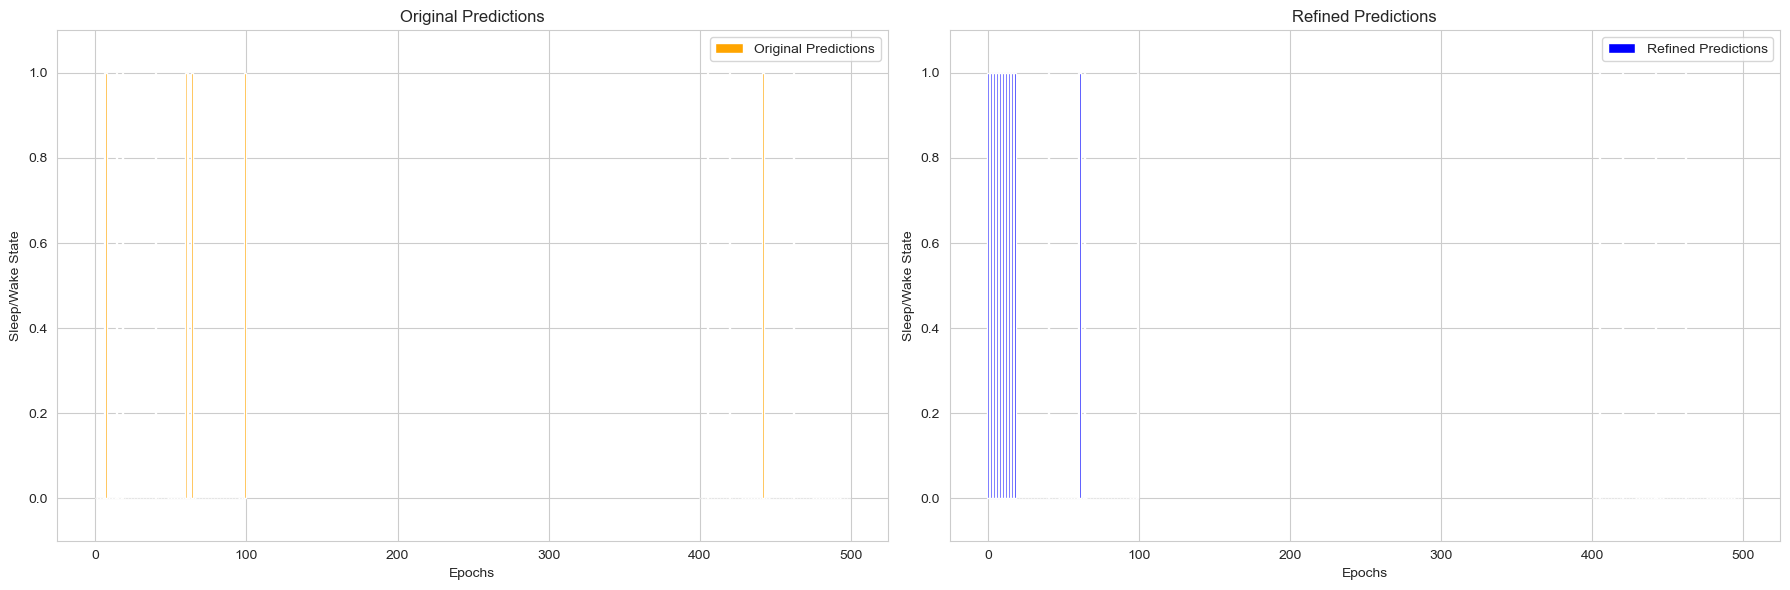

((205650, 14490, 93.41782502044154), (203175, 16965, 92.29354047424366))

In [61]:
x = list(range(100)) + list(range(400, 500))  # epochs
y1_original = original
y2_refined = refined

plt.figure(figsize=(18, 6))

# Original predictions
plt.subplot(1, 2, 1)
plt.bar(x, y1_original, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

# Refined predictions
plt.subplot(1, 2, 2)
plt.bar(x, y2_refined, color='blue', label='Refined Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions')
plt.legend()

plt.tight_layout()
plt.show()


# Compute metrics for the refined predictions
refined_TST, refined_TWT, refined_SE = compute_sleep_metrics(refined_pred_htweights)

# Compute metrics for the ground truth (Actiwatch classifications)
ground_truth_TST, ground_truth_TWT, ground_truth_SE = compute_sleep_metrics(y_test.values)

refined_metrics = (refined_TST, refined_TWT, refined_SE)
ground_truth_metrics = (ground_truth_TST, ground_truth_TWT, ground_truth_SE)

refined_metrics, ground_truth_metrics


In [62]:
def refine_predictions_60min(preds):
    """
    Refine the predictions based on the continuity rules for 60 minutes of uninterrupted sleep.
    """
    refined_preds = preds.tolist()

    # First 60 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 240):  # 240 epochs = 60 minutes
        if all([epoch == 0 for epoch in refined_preds[i:i+240]]):
            # Set all epochs before this to wake
            for j in range(i):
                refined_preds[j] = 1
            break

    # Last 60 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 240, 0, -1):
        if all([epoch == 0 for epoch in refined_preds[i:i+240]]):
            # Set all epochs after this to wake
            for j in range(i+240, len(refined_preds)):
                refined_preds[j] = 1
            break

    return np.array(refined_preds)

# Apply post-processing to the predictions from SVM with Weights and Hyperparameter Tuning for 60 minutes rule
refined_pred_60min = refine_predictions_60min(y_pred_htweights)

# Check the first and last 100 epochs to see the changes for the 60 minutes rule
original_60min = y_pred_htweights[:100].tolist() + y_pred_htweights[-100:].tolist()
refined_60min = refined_pred_60min[:100].tolist() + refined_pred_60min[-100:].tolist()

refined_60min, original_60min


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,

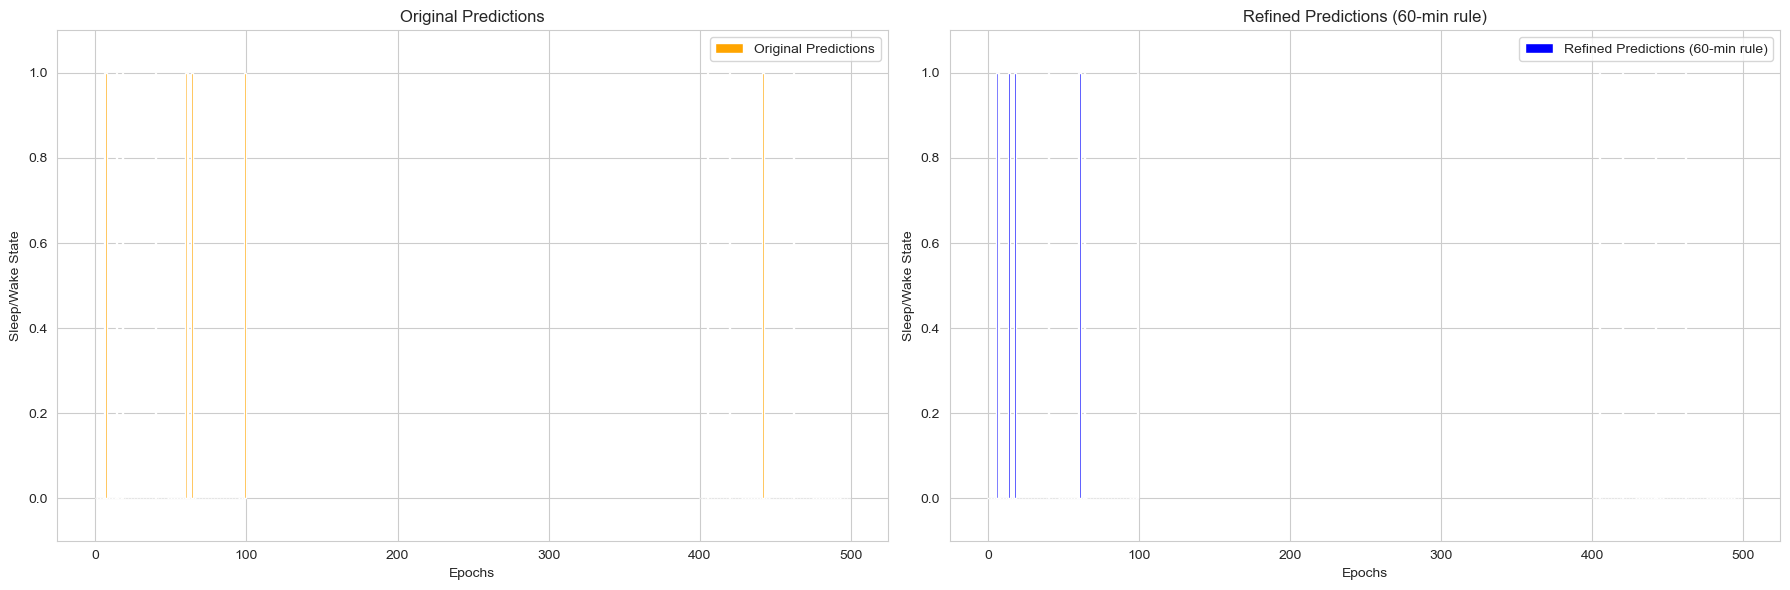

(205875, 14265, 93.52003270645952)

In [63]:
# Apply post-processing to the predictions from SVM with Weights and Hyperparameter Tuning using the 60-minute rule
refined_pred_60min = refine_predictions_60min(y_pred_htweights)

# Check the first and last 100 epochs to see the changes
original_60min = y_pred_htweights[:100].tolist() + y_pred_htweights[-100:].tolist()
refined_60min = refined_pred_60min[:100].tolist() + refined_pred_60min[-100:].tolist()

# pltting
x_60min = list(range(100)) + list(range(400, 500))  # epochs
y1_original_60min = original_60min
y2_refined_60min = refined_60min

plt.figure(figsize=(18, 6))

# Original predictions
plt.subplot(1, 2, 1)
plt.bar(x_60min, y1_original_60min, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

# Refined predictions using 60-minute rule
plt.subplot(1, 2, 2)
plt.bar(x_60min, y2_refined_60min, color='blue', label='Refined Predictions (60-min rule)')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions (60-min rule)')
plt.legend()

plt.tight_layout()
plt.show()

# Compute metrics for the refined predictions using 60-minute rule
refined_TST_60min, refined_TWT_60min, refined_SE_60min = compute_sleep_metrics(refined_pred_60min)

refined_metrics_60min = (refined_TST_60min, refined_TWT_60min, refined_SE_60min)
refined_metrics_60min
